<a href="https://colab.research.google.com/github/xarvel/DataScience/blob/master/ResNet_birds.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [16]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

print("Tensorflow version " + tf.__version__)

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
Tensorflow version 2.8.2


In [17]:
resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='')
tf.config.experimental_connect_to_cluster(resolver)
# This is the TPU initialization code that has to be at the beginning.
tf.tpu.experimental.initialize_tpu_system(resolver)
print("All devices: ", tf.config.list_logical_devices('TPU'))
tpu_strategy = tf.distribute.TPUStrategy(resolver)

All devices:  [LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:0', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:1', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:2', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:3', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:4', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:5', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:6', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:7', device_type='TPU')]


In [18]:
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from matplotlib import pyplot as plt

AUTO = tf.data.experimental.AUTOTUNE

IMAGE_SIZE = [224, 224]
NUM_CLASSES = 100

def data_augment(image, label):
  modified = tf.image.random_flip_left_right(image)
  modified = tf.image.random_flip_up_down(modified)
  modified = tf.image.random_saturation(modified, 0, 2)
  #modified = tf.keras.preprocessing.image.random_shift(modified, 0.5, 0.5)
  #modified = tf.keras.preprocessing.image.random_shear(modified, 0.5)
  #modified = tf.keras.preprocessing.image.random_zoom(modified, 0.5)

  return modified, label

def parse_tfrecord(example):
  features = {
     "image": tf.io.FixedLenFeature([], tf.string), 
     'height': tf.io.FixedLenFeature([], tf.int64),
     'width': tf.io.FixedLenFeature([], tf.int64),
     'channels': tf.io.FixedLenFeature([], tf.int64),
     'label_text': tf.io.FixedLenFeature([], tf.string), 
     'label_onehot':  tf.io.FixedLenSequenceFeature([], tf.int64, allow_missing=True),
     'label_number': tf.io.FixedLenFeature([], tf.int64),
  }
  example = tf.io.parse_single_example(example, features)
  decoded = tf.image.decode_jpeg(example['image'], channels=3)
  resized = tf.image.resize(decoded, (224, 224))

  normalized = tf.cast(resized, tf.float32) / 255.0
  image_tensor = tf.reshape(normalized, [*IMAGE_SIZE, 3])
  
  label_onehot = example['label_onehot']

  return image_tensor, label_onehot  

def open_images_with_labels(filenames):
  records = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTO)
  return records.map(parse_tfrecord, num_parallel_calls=AUTO) 

gcs_pattern = 'gs://brids-xarvel/*.tfrec'
filenames = tf.io.gfile.glob(gcs_pattern)

dataset = open_images_with_labels(filenames)  
dataset = dataset.shuffle(13000)

validation_dataset = dataset.take(1000).batch(100).prefetch(AUTO) 
train_dataset = dataset.skip(1000).map(data_augment, num_parallel_calls=AUTO).repeat().batch(100).prefetch(AUTO) 

In [19]:
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.layers import Flatten, Dense, Dropout, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.applications.resnet_v2 import ResNet152V2
from tensorflow.keras.applications import Xception

def create_model():
  pretrained_model = ResNet152V2(input_shape=[*IMAGE_SIZE, 3], include_top=False, weights=None)
  pretrained_model.trainable = True
  model = Sequential([
    pretrained_model,
    GlobalAveragePooling2D(),
    Dense(NUM_CLASSES, activation='softmax')
  ])
  model.compile(
    optimizer = 'adam',
    loss = 'categorical_crossentropy',
    metrics = ['accuracy']
  )
  return model

with tpu_strategy.scope(): 
  model = create_model()

history = model.fit(
    train_dataset,
    steps_per_epoch=400,
    validation_data=validation_dataset,
    epochs=30,
)

Epoch 1/30


400/400 [==============================] - 222s 224ms/step - loss: 3.8569 - accuracy: 0.1047 - val_loss: 10.3451 - val_accuracy: 0.0350
Epoch 2/30
400/400 [==============================] - 74s 186ms/step - loss: 2.6570 - accuracy: 0.3234 - val_loss: 3.8767 - val_accuracy: 0.2270
Epoch 3/30
400/400 [==============================] - 75s 186ms/step - loss: 1.8163 - accuracy: 0.5229 - val_loss: 4.6555 - val_accuracy: 0.2730
Epoch 4/30
400/400 [==============================] - 75s 188ms/step - loss: 1.2443 - accuracy: 0.6658 - val_loss: 1.4535 - val_accuracy: 0.6180
Epoch 5/30
400/400 [==============================] - 75s 187ms/step - loss: 0.8725 - accuracy: 0.7594 - val_loss: 1.1332 - val_accuracy: 0.7010
Epoch 6/30
400/400 [==============================] - 75s 187ms/step - loss: 0.6356 - accuracy: 0.8219 - val_loss: 1.2129 - val_accuracy: 0.6580
Epoch 7/30
400/400 [==============================] - 75s 187ms/step - loss: 0.4764 - accuracy: 0.8631 - val_loss: 0.8128 - val_accuracy: 0

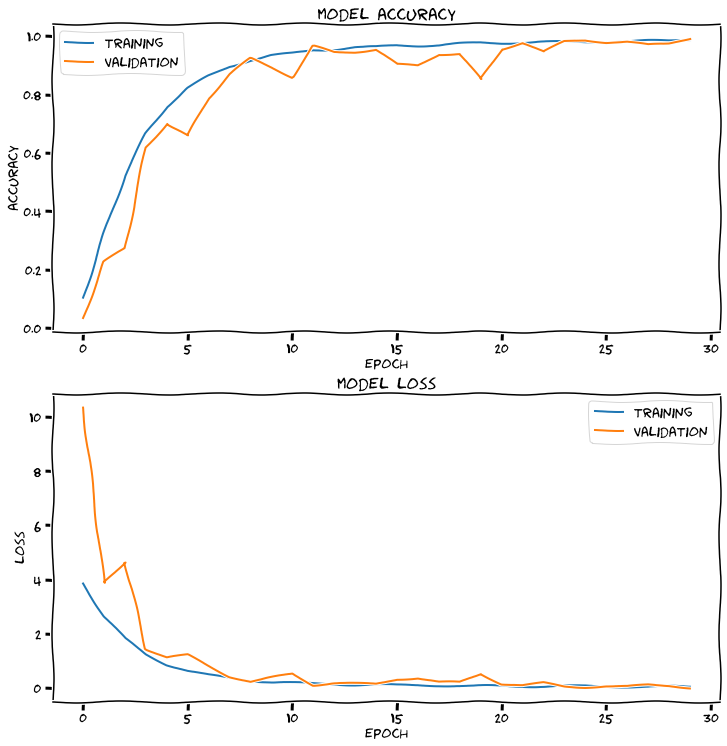

In [20]:
def display_training_curves(training, validation, title, subplot):
  with plt.xkcd():
    ax = plt.subplot(subplot)
    ax.plot(training)
    ax.plot(validation)
    ax.set_title('model '+ title)
    ax.set_ylabel(title)
    ax.set_xlabel('epoch')
    ax.legend(['training', 'validation'])

plt.subplots(figsize=(10,10))
plt.tight_layout()
display_training_curves(history.history['accuracy'], history.history['val_accuracy'], 'accuracy', 211)
display_training_curves(history.history['loss'], history.history['val_loss'], 'loss', 212)

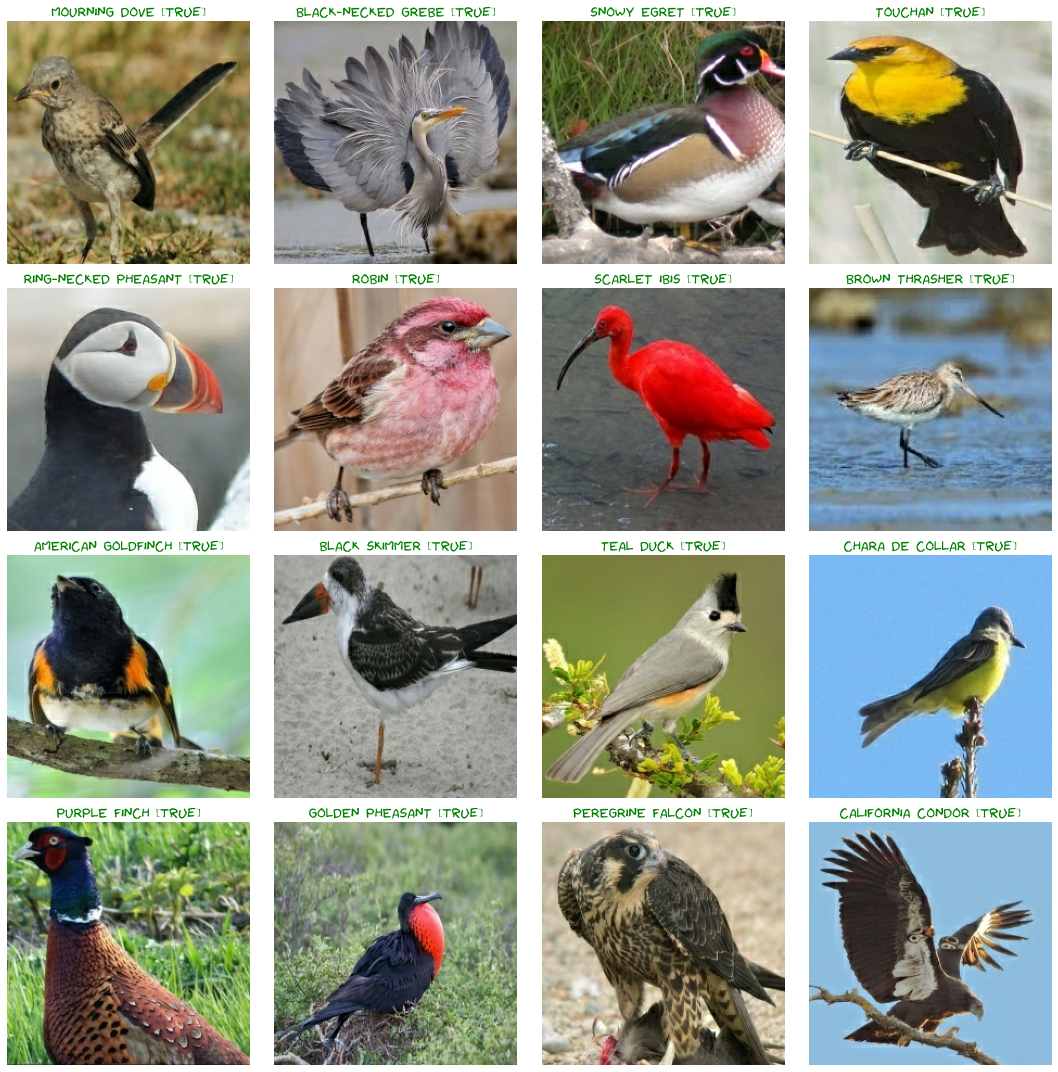

In [21]:
import numpy as np
evaluation_dataset = dataset.take(16).batch(16).prefetch(AUTO)

text_labels = ['AMERICAN KESTREL', 'AMERICAN REDSTART', 'ANNAS HUMMINGBIRD', 
          'AMERICAN GOLDFINCH', 'BALD EAGLE', 'ALBATROSS', 'CACTUS WREN', 
          'BLACK-CAPPED CHICKADEE', 'BROWN THRASHER', 'BLACKBURNIAM WARBLER',
          'BARN OWL', 'BANANAQUIT', 'BAR-TAILED GODWIT', 'BAY-BREASTED WARBLER',
          'BLACK SKIMMER', 'BOBOLINK', 'BALTIMORE ORIOLE', 'BELTED KINGFISHER', 
          'BLACK-NECKED GREBE', 'BIRD OF PARADISE', 'BARN SWALLOW', 
          'BLUE HERON', 'CALIFORNIA CONDOR', 'CROW', 'CAPE MAY WARBLER', 
          'CHIPPING SPARROW', 'CALIFORNIA GULL', 'COUCHS KINGBIRD', 
          'CRESTED AUKLET', 'CINNAMON TEAL', 'EASTERN BLUEBIRD', 
          'CHARA DE COLLAR', 'CALIFORNIA QUAIL', 'COCKATOO', 
          'COMMON LOON', 'DOWNY WOODPECKER', 'CRESTED CARACARA', 'GOLDEN EAGLE',
          'GRAY CATBIRD', 'FRIGATE', 'FLAME TANAGER', 'EASTERN TOWEE', 
          'GOLD WING WARBLER', 'GOLDEN PHEASANT', 'HAWAIIAN GOOSE', 
          'HOODED MERGANSER', 'FLAMINGO', 'GOULDIAN FINCH', 'GREY PLOVER', 
          'EMPEROR PENGUIN', 'HOOPOES', 'EVENING GROSBEAK', 'ELEGANT TROGON', 
          'INDIGO BUNTING', 'NORTHERN MOCKINGBIRD', 'LARK BUNTING', 
          'LONG-EARED OWL', 'OSTRICH', 'NICOBAR PIGEON', 'NORTHERN CARDINAL', 
          'NORTHERN GOSHAWK', 'LILAC ROLLER', 'MALLARD DUCK', 'HOUSE SPARROW', 
          'MANDRIN DUCK', 'HYACINTH MACAW', 'HOUSE FINCH', 'MYNA', 
          'MOURNING DOVE', 'NORTHERN FLICKER', 'PURPLE MARTIN', 
          'RUBY THROATED HUMMINGBIRD', 'QUETZAL', 'PEREGRINE FALCON', 
          'RING-NECKED PHEASANT', 'ROBIN', 'PUFFIN', 'RED WINGED BLACKBIRD', 
          'SAND MARTIN', 'RED HEADED WOODPECKER', 'ROADRUNNER', 'PURPLE FINCH', 
          'PELICAN', 'RED FACED CORMORANT', 'PAINTED BUNTIG', 'PEACOCK', 
          'ROUGH LEG BUZZARD', 'SCARLET IBIS', 'SCARLET MACAW', 'SPLENDID WREN',
          'YELLOW HEADED BLACKBIRD', 'TURKEY VULTURE', 
          'STORK BILLED KINGFISHER', 'TEAL DUCK', 'VERMILION FLYCATHER', 
          'TIT MOUSE', 'WESTERN MEADOWLARK', 'WOOD DUCK', 'SNOWY EGRET', 
          'TOUCHAN']

def display_image(image, predicted_label, true_label, index):
  with plt.xkcd():
    plt.subplot(4, 4, index)
    plt.axis('off')
    title = text_labels[true_label]
    veryfication_title = 'true' if predicted_label == true_label else 'false'
    color = 'green' if predicted_label == true_label else 'red'

    plt.title(title + ' [' + veryfication_title + ']', fontsize=14, color=color)
    plt.imshow(image)
  
images, true_one_hot_labels = evaluation_dataset.as_numpy_iterator().next()
predicted_one_hot_labels = model.predict(images)
predicted_labels = np.argmax(predicted_one_hot_labels, axis=1)
true_labels = np.argmax(true_one_hot_labels, axis=1)

images_labels = zip(images, predicted_labels, true_labels)

subplot = 441
plt.figure(figsize=(15,15))
i = 1
for image, predicted_label, true_label in images_labels:
  display_image(image, predicted_label, true_label, i)  
  i = i + 1
plt.tight_layout()
plt.subplots_adjust(wspace=0.1, hspace=0.1)
plt.show()

In [22]:
loss, acc = model.evaluate(dataset.take(1000).batch(100))

10/10 [==============================] - 3s 74ms/step - loss: 0.0216 - accuracy: 0.9940


In [23]:
'Accuracy: ' + str(acc)

'Accuracy: 0.9940000176429749'